<a href="https://colab.research.google.com/github/WalkerSue/colab/blob/torch/AlexNet_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw
Processing...
Done!



Train Data Size: torch.Size([60000, 28, 28])
Train Label Size: torch.Size([60000])


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:63: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/dat

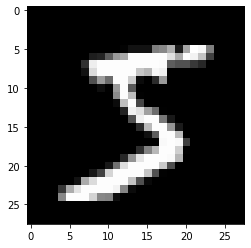

In [1]:
# 数据加载
import torch
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import  torchvision.transforms as transforms

from torch import nn, optim
import torchvision
import torch.nn.functional as F

#超参数定义
EPOCH = 10
BATCH_SIZE = 64
LR = 0.001

train_data = datasets.MNIST(root='./mnist/', train=True, transform=transforms.ToTensor(), download=True)
test_data = datasets.MNIST(root='./mnist/', train=False, transform=transforms.ToTensor(), download=True)

test_x = test_data.test_data.type(torch.FloatTensor)[:2000]/255.
test_y = test_data.test_labels.numpy()[:2000]

import matplotlib.pyplot as plt
%matplotlib inline
print ("Train Data Size:", train_data.train_data.size())
print ("Train Label Size:", train_data.train_labels.size())

plt.imshow(train_data.train_data[0].numpy(), cmap="gray")
plt.show()

In [2]:
# Hyper-parameters 
EPOCH = 10
BATCH_SIZE = 64
LR = 0.001
# device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# 使用DataLoader 进行分批
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

In [3]:
# model = NeuralNet().to(device)
class ModelEval():
    def __init__(self, Model, train_loader, test_loader, device, EPOCH, LR, flat=False):
        # 判断输入是否平铺
        self.flat = flat
        # model 实例化
        self.total_step = len(train_loader)
        self.Model = Model
        self.model = Model().to(device)
        # Loss and optimizer
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=LR)  

        # Train the model
        self.train()
        self.val()
        
    def train(self):
        for epoch in range(EPOCH):
            train_loss = 0
            correct = 0
            for i, (images, labels) in enumerate(train_loader):  
                # Move tensors to the configured device
                if self.flat:
                    self.images = images.reshape(-1, 28*28).to(device)
                else:
                    self.images = images.to(device)
                self.labels = labels.to(device)

                # Forward pass
                self.outputs = self.model(self.images)
                self.loss = self.criterion(self.outputs, self.labels)

                # Backward and optimize
                self.optimizer.zero_grad()
                self.loss.backward()
                self.optimizer.step()
                
                # 准确性评估
                train_loss += self.loss
                pred = self.outputs.argmax(dim=1, keepdim=True)
                correct += pred.eq(self.labels.long().view_as(pred)).sum().item()

                if (i+1) % 100 == 0:
                    print ('Model:{},Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                           .format(self.Model, epoch+1, EPOCH, i+1, self.total_step, self.loss.item()))
            # 每一个epoch 进行准确性评估输出
            print ('Model:{},Epoch [{}] finished,Loss:{:.4f},Accuracy:{:.2f}%'.format(
                    self.Model, epoch+1, train_loss/(i+1), 100*correct/len(train_loader.dataset)))
    def val(self):
        # Test the model
        # In test phase, we don't need to compute gradients (for memory efficiency)
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_loader:
                if self.flat:
                    images = images.reshape(-1, 28*28).to(device)
                else:
                    images = images.to(device)
                labels = labels.to(device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

In [10]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10, init_weights=False):   
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(  #打包 
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # input[1, 28, 28]  output[32, 28, 28] 自动舍去小数点后
            nn.ReLU(inplace=True), #inplace 可以载入更大模型
            nn.MaxPool2d(kernel_size=2, stride=2),                  # output[32, 14, 14] kernel_num为原论文一半
            nn.Conv2d(32, 64, kernel_size=3, padding=1),           # output[64, 14, 14]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                  # output[64, 7, 7]
            nn.Conv2d(64, 128, kernel_size=3, padding=1),          # output[128, 7, 7]
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),          # output[256, 7, 7]
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),          # output[256, 7, 7]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                  # output[256, 3, 3]
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.1),
            #全链接
            nn.Linear(256 * 3 * 3, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1) #展平   或者view()
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu') #何教授方法
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)  #正态分布赋值
                nn.init.constant_(m.bias, 0)
        

In [11]:
ModelEval(AlexNet, train_loader, test_loader, device, EPOCH, LR, flat=False)

Model:<class '__main__.AlexNet'>,Epoch [1/10], Step [100/938], Loss: 0.7332
Model:<class '__main__.AlexNet'>,Epoch [1/10], Step [200/938], Loss: 0.2673
Model:<class '__main__.AlexNet'>,Epoch [1/10], Step [300/938], Loss: 0.0400
Model:<class '__main__.AlexNet'>,Epoch [1/10], Step [400/938], Loss: 0.0666
Model:<class '__main__.AlexNet'>,Epoch [1/10], Step [500/938], Loss: 0.1469
Model:<class '__main__.AlexNet'>,Epoch [1/10], Step [600/938], Loss: 0.0964
Model:<class '__main__.AlexNet'>,Epoch [1/10], Step [700/938], Loss: 0.0867
Model:<class '__main__.AlexNet'>,Epoch [1/10], Step [800/938], Loss: 0.1612
Model:<class '__main__.AlexNet'>,Epoch [1/10], Step [900/938], Loss: 0.1372
Model:<class '__main__.AlexNet'>,Epoch [1] finished,Loss:0.2678,Accuracy:91.09%
Model:<class '__main__.AlexNet'>,Epoch [2/10], Step [100/938], Loss: 0.0472
Model:<class '__main__.AlexNet'>,Epoch [2/10], Step [200/938], Loss: 0.1497
Model:<class '__main__.AlexNet'>,Epoch [2/10], Step [300/938], Loss: 0.0550
Model:<c

In [6]:
# 全连接网络
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.input_size = 784
        self.hidden_size = 500
        self.num_classes = 10
        self.fc1 = nn.Linear(self.input_size, self.hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(self.hidden_size, self.num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [7]:
ModelEval(NeuralNet, train_loader, test_loader, device, EPOCH, LR, flat=True)

Model:<class '__main__.NeuralNet'>,Epoch [1/10], Step [100/938], Loss: 0.2119
Model:<class '__main__.NeuralNet'>,Epoch [1/10], Step [200/938], Loss: 0.3825
Model:<class '__main__.NeuralNet'>,Epoch [1/10], Step [300/938], Loss: 0.2391
Model:<class '__main__.NeuralNet'>,Epoch [1/10], Step [400/938], Loss: 0.2500
Model:<class '__main__.NeuralNet'>,Epoch [1/10], Step [500/938], Loss: 0.2491
Model:<class '__main__.NeuralNet'>,Epoch [1/10], Step [600/938], Loss: 0.2425
Model:<class '__main__.NeuralNet'>,Epoch [1/10], Step [700/938], Loss: 0.1095
Model:<class '__main__.NeuralNet'>,Epoch [1/10], Step [800/938], Loss: 0.1107
Model:<class '__main__.NeuralNet'>,Epoch [1/10], Step [900/938], Loss: 0.0634
Model:<class '__main__.NeuralNet'>,Epoch [1] finished,Loss:0.2582,Accuracy:92.61%
Model:<class '__main__.NeuralNet'>,Epoch [2/10], Step [100/938], Loss: 0.0156
Model:<class '__main__.NeuralNet'>,Epoch [2/10], Step [200/938], Loss: 0.0945
Model:<class '__main__.NeuralNet'>,Epoch [2/10], Step [300/9

In [8]:
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        # 定义第一层卷积层，1个输入通道，6个输出通道，5*5的filter,28+2+2=32 padding 填充
        # 左右，上下填充padding=2
        # MNIST图像大小是28，LeNet大小是32
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        # 定义第二层卷积层
        self.conv2 = nn.Conv2d(6, 16, 5)
        # 定义三个全连接层
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    # 向前传播    
    def forward(self, x):
        # 先卷积，再用relu激活函数，然后再最大值池化
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        # num_flat_features = 16*5*5
        # 摊平
        x = x.view(-1, self.num_flat_features(x))
        
        #第一个全连接
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features = num_features * s
        return num_features

In [9]:
ModelEval(LeNet5, train_loader, test_loader, device, EPOCH, LR, flat=False)

Model:<class '__main__.LeNet5'>,Epoch [1/10], Step [100/938], Loss: 0.4386
Model:<class '__main__.LeNet5'>,Epoch [1/10], Step [200/938], Loss: 0.3332
Model:<class '__main__.LeNet5'>,Epoch [1/10], Step [300/938], Loss: 0.1230
Model:<class '__main__.LeNet5'>,Epoch [1/10], Step [400/938], Loss: 0.3333
Model:<class '__main__.LeNet5'>,Epoch [1/10], Step [500/938], Loss: 0.1431
Model:<class '__main__.LeNet5'>,Epoch [1/10], Step [600/938], Loss: 0.0672
Model:<class '__main__.LeNet5'>,Epoch [1/10], Step [700/938], Loss: 0.2081
Model:<class '__main__.LeNet5'>,Epoch [1/10], Step [800/938], Loss: 0.0556
Model:<class '__main__.LeNet5'>,Epoch [1/10], Step [900/938], Loss: 0.0212
Model:<class '__main__.LeNet5'>,Epoch [1] finished,Loss:0.2863,Accuracy:90.92%
Model:<class '__main__.LeNet5'>,Epoch [2/10], Step [100/938], Loss: 0.0356
Model:<class '__main__.LeNet5'>,Epoch [2/10], Step [200/938], Loss: 0.0656
Model:<class '__main__.LeNet5'>,Epoch [2/10], Step [300/938], Loss: 0.0192
Model:<class '__main_